In [62]:
import os, pickle, time, IPython
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ble_afh
from ble_afh.utils.AFHTracer import AFHTracer
from ble_afh.utils.log_parser.feather_log_parser import FeatherLogParser
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

eAFH_COLOR='orange'
GRAZ_COLOR='#0571b0'

In [2]:
#TRACES_LOCATION = "/Users/valentin/research/rl-ble-data/parsed_logs/eval"
APT_TRACES_LOCATION = "/Users/valentin/research/rl-ble-data/parsed_logs/apt"
#DCUBE_TRACES_LOCATION = "/Users/valentin/research/rl-ble-data/parsed_logs/dcube"
CONNECTION_EVENT = 20/1000

## TRACES TO EVALUATE

In [146]:
trace_names = ["eval_macro_eafh_vs_continuous_1_10min_run0.feather",
               "eval_macro_eafh_vs_continuous_1_10min_run1.feather",
               "eval_macro_eafh_vs_continuous_1_10min_run2.feather",
               "eval_macro_eafh_vs_continuous_1_10min_run3.feather",
               "eval_macro_eafh_vs_continuous_1_10min_run4.feather",
               "eval_macro_eafh_vs_slow_dynamics_10min_run0.feather",
               "eval_macro_eafh_vs_slow_dynamics_10min_run1.feather",
               "eval_macro_eafh_vs_slow_dynamics_10min_run2.feather",
               "eval_macro_eafh_vs_slow_dynamics_10min_run3.feather",
               "eval_macro_eafh_vs_slow_dynamics_10min_run4.feather",
               "eval_macro_eafh_vs_fast_dynamics_10min_run0.feather",
               "eval_macro_eafh_vs_fast_dynamics_10min_run1.feather",
               "eval_macro_eafh_vs_fast_dynamics_10min_run2.feather",
               "eval_macro_eafh_vs_fast_dynamics_10min_run3.feather",
               "eval_macro_eafh_vs_fast_dynamics_10min_run4.feather",
               "eval_macro_eafh_vs_2meters_10min_run0.feather",
               "eval_macro_eafh_vs_2meters_10min_run1.feather",
               "eval_macro_eafh_vs_2meters_10min_run2.feather",
               "eval_macro_eafh_vs_2meters_10min_run3.feather",
               "eval_macro_eafh_vs_2meters_10min_run4.feather",
               #
               "eval_macro_graz_vs_continuous_1_10min_run0.feather",
               "eval_macro_graz_vs_continuous_1_10min_run1.feather",
               "eval_macro_graz_vs_continuous_1_10min_run2.feather",
               "eval_macro_graz_vs_continuous_1_10min_run3.feather",
               "eval_macro_graz_vs_continuous_1_10min_run4.feather",
               "eval_macro_eafh_vs_slow_dynamics_10min_run0.feather",
               "eval_macro_graz_vs_slow_dynamics_10min_run1.feather",
               "eval_macro_graz_vs_slow_dynamics_10min_run2.feather",
               "eval_macro_graz_vs_slow_dynamics_10min_run3.feather",
               "eval_macro_graz_vs_slow_dynamics_10min_run4.feather",
               "eval_macro_graz_vs_fast_dynamics_10min_run0.feather",
               "eval_macro_graz_vs_fast_dynamics_10min_run1.feather",
               "eval_macro_graz_vs_fast_dynamics_10min_run2.feather",
               "eval_macro_graz_vs_fast_dynamics_10min_run3.feather",
               "eval_macro_graz_vs_fast_dynamics_10min_run4.feather",
               "eval_macro_graz_vs_2meters_10min_run0.feather",
               "eval_macro_graz_vs_2meters_10min_run1.feather",
               "eval_macro_graz_vs_2meters_10min_run2.feather",
               "eval_macro_graz_vs_2meters_10min_run3.feather",
               "eval_macro_graz_vs_2meters_10min_run4.feather",
               #
               "eval_macro_nafh_vs_continuous_1_10min_run0.feather",
               "eval_macro_nafh_vs_continuous_1_10min_run1.feather",
               "eval_macro_nafh_vs_continuous_1_10min_run2.feather",
               "eval_macro_nafh_vs_continuous_1_10min_run3.feather",
               "eval_macro_nafh_vs_continuous_1_10min_run4.feather",
               "eval_macro_nafh_vs_slow_dynamics_10min_run0.feather",
               "eval_macro_nafh_vs_slow_dynamics_10min_run1.feather",
               "eval_macro_nafh_vs_slow_dynamics_10min_run2.feather",
               "eval_macro_nafh_vs_slow_dynamics_10min_run3.feather",
               "eval_macro_nafh_vs_slow_dynamics_10min_run4.feather",
               "eval_macro_nafh_vs_fast_dynamics_10min_run0.feather",
               "eval_macro_nafh_vs_fast_dynamics_10min_run1.feather",
               "eval_macro_nafh_vs_fast_dynamics_10min_run2.feather",
               "eval_macro_nafh_vs_fast_dynamics_10min_run3.feather",
               "eval_macro_nafh_vs_fast_dynamics_10min_run4.feather",
               "eval_macro_nafh_vs_2meters_1_10min_run0.feather",
               "eval_macro_nafh_vs_2meters_1_10min_run1.feather",
               "eval_macro_nafh_vs_2meters_1_10min_run2.feather",
               "eval_macro_nafh_vs_2meters_1_10min_run3.feather",
               "eval_macro_nafh_vs_2meters_1_10min_run4.feather",
               "eval_macro_nafh_vs_ble_10min_run0.feather",
               "eval_macro_nafh_vs_ble_10min_run1.feather",
               "eval_macro_nafh_vs_ble_10min_run2.feather",
               "eval_macro_nafh_vs_ble_10min_run3.feather",
               "eval_macro_nafh_vs_ble_10min_run4.feather",
               #
              ]
exp_data = []
rf_data_parser = FeatherLogParser()

for trace in trace_names:
    exp_data.append(rf_data_parser.parse(os.path.join(APT_TRACES_LOCATION, trace)))

## Data extraction helpers

In [4]:
def extract_data_from_feather(rf_data):
    exp = dict()
    # channel map per event
    chan_map = np.zeros((rf_data.channel_map.shape[0],37))
    # dta staleness, per channel and event
    staleness = np.zeros((rf_data.channel_map.shape[0],37))
    # consecutive losses per channel
    consecutive_losses = np.zeros((11,))
    loss =0
    # number of consecutive losses so far, per channel
    loss_per_chan = np.zeros((37,))
    # Number of channel_map updates
    nb_chanmap_update = 0
    prev_chm = np.ones((37,))
    prev_chm[37:] = 0
    # losses per second
    losses = -(rf_data.pdr-1)
    losses_sw = np.zeros((int(len(losses)*CONNECTION_EVENT),))
    step = int(1/CONNECTION_EVENT)
    for i in range(0,losses_sw.shape[0]):
        losses_sw[i] = np.sum(losses[i*step:(i+1)*step])
    for ev in range(rf_data.channel_map.shape[0]):
        chm = str(bin(rf_data.channel_map[ev]))[2:]
        if len(chm)<37:
            chm = ''.join(['0']*(37-len(chm)))+chm
        chan_map[ev] = (np.array([int(d) for d in chm]))[::-1]
        if not np.array_equal(chan_map[ev], prev_chm):
            nb_chanmap_update += 1
        prev_chm = chan_map[ev]
        
        if ev>0:
            staleness[ev] = staleness[ev-1]+1
        staleness[ev,rf_data.channel[ev]] = 0
        if rf_data.pdr[ev] == 0:
            loss+=1
        elif rf_data.pdr[ev] == 1 and loss>0:
            consecutive_losses[min(loss-1,10)]+=1
            loss=0
            #loss_per_chan[rf_data.channel[ev]] += 1
        #else:
            #if not loss_per_chan[rf_data.channel[ev]]==0:
                #consecutive_losses_per_chan[int(loss_per_chan[rf_data.channel[ev]]-1)] +=1
                #loss_per_chan[rf_data.channel[ev]] = 0
    # add last losses
#     for ch in range(37):
#         if not loss_per_chan[ch]==0:
#                 consecutive_losses_per_chan[int(loss_per_chan[ch]-1)] +=1
# #                 print(f"{int(loss_per_chan[ch]-1)} losses on channel {ch} [-1]")
#                 loss_per_chan[ch] = 0
        
    exp['pdr'] = np.sum(rf_data.pdr)/rf_data.channel_map.shape[0]*100
    exp['conn_events'] = rf_data.pdr
    exp['losses_per_sec'] = losses_sw
    exp['channel_map'] = chan_map
    exp['staleness'] = staleness
    exp['consecutive_losses'] = consecutive_losses
    exp['total_loss'] = np.sum(rf_data.pdr==0)
    exp['updates'] = nb_chanmap_update
    exp['channel_diversity'] = np.nanmean(np.sum(chan_map,axis=1))
    exp['channel_diversity_std'] = np.nanstd(np.sum(chan_map,axis=1))
    return exp

In [147]:
exp_stats = [extract_data_from_feather(exp) for exp in exp_data]

In [148]:
eafh = dict()
eafh['wifi1'] = dict()
pos = 0
eafh['wifi1']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
eafh['wifi1']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
eafh['wifi1']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
eafh['wifi1']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
eafh['slow'] = dict()
pos+=5
eafh['slow']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
eafh['slow']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
eafh['slow']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
eafh['slow']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
eafh['fast'] = dict()
pos+=5
eafh['fast']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
eafh['fast']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
eafh['fast']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
eafh['fast']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
eafh['dist'] = dict()
pos+=5
eafh['dist']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
eafh['dist']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
eafh['dist']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
eafh['dist']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]

graz = dict()
graz['wifi1'] = dict()
pos+=5
graz['wifi1']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
graz['wifi1']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
graz['wifi1']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
graz['wifi1']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
graz['slow'] = dict()
pos+=5
graz['slow']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
graz['slow']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
graz['slow']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
graz['slow']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
graz['fast'] = dict()
pos+=5
graz['fast']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
graz['fast']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
graz['fast']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
graz['fast']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
graz['dist'] = dict()
pos+=5
graz['dist']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
graz['dist']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
graz['dist']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
graz['dist']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]

nafh = dict()
nafh['wifi1'] = dict()
pos+=5
nafh['wifi1']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
nafh['wifi1']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
nafh['wifi1']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
nafh['wifi1']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
nafh['slow'] = dict()
pos+=5
nafh['slow']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
nafh['slow']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
nafh['slow']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
nafh['slow']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
nafh['fast'] = dict()
pos+=5
nafh['fast']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+5)]
nafh['fast']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+5)]
nafh['fast']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+5)]
nafh['fast']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+5)]
nafh['dist'] = dict()
pos+=5
nafh['dist']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+3)]
nafh['dist']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+3)]
nafh['dist']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+3)]
nafh['dist']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+3)]
nafh['blee'] = dict()
pos+=5
nafh['blee']['pdr'] = [exp_stats[i]['pdr'] for i in range(pos,pos+3)]
nafh['blee']['channel_maps'] = [exp_stats[i]['channel_map'] for i in range(pos,pos+3)]
nafh['blee']['updates'] = [exp_stats[i]['updates'] for i in range(pos,pos+3)]
nafh['blee']['channels'] = [np.sum(exp_stats[i]['channel_map'],axis=1) for i in range(pos,pos+3)]

In [136]:
eafh_pdr = [np.nanmean(eafh['wifi1']['pdr']),
            np.nanmean(eafh['slow']['pdr']),
            np.nanmean(eafh['fast']['pdr']),
            np.nanmean(eafh['dist']['pdr']),
           ]
graz_pdr = [np.nanmean(graz['wifi1']['pdr']),
            np.nanmean(graz['slow']['pdr']),
            np.nanmean(graz['fast']['pdr']),
            np.nanmean(graz['dist']['pdr']),
           ]
nafh_pdr = [np.nanmean(nafh['wifi1']['pdr']),
            np.nanmean(nafh['slow']['pdr']),
            np.nanmean(nafh['fast']['pdr']),
            np.nanmean(nafh['dist']['pdr']),
           ]

eafh_pdr_std = [np.nanstd(eafh['wifi1']['pdr']),
            np.nanstd(eafh['slow']['pdr']),
            np.nanstd(eafh['fast']['pdr']),
            np.nanstd(eafh['dist']['pdr']),
           ]
graz_pdr_std = [np.nanstd(graz['wifi1']['pdr']),
            np.nanstd(graz['slow']['pdr']),
            np.nanstd(graz['fast']['pdr']),
            np.nanstd(graz['dist']['pdr']),
           ]
nafh_pdr_std = [np.nanstd(nafh['wifi1']['pdr']),
            np.nanstd(nafh['slow']['pdr']),
            np.nanstd(nafh['fast']['pdr']),
            np.nanstd(nafh['dist']['pdr']),
           ]

eafh_upd = [np.nanmean(eafh['wifi1']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(eafh['slow']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(eafh['fast']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(eafh['dist']['updates'])*100*CONNECTION_EVENT/(10*60),
           ]
graz_upd = [np.nanmean(graz['wifi1']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(graz['slow']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(graz['fast']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(graz['dist']['updates'])*100*CONNECTION_EVENT/(10*60),
           ]
nafh_upd = [np.nanmean(nafh['wifi1']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(nafh['slow']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(nafh['fast']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanmean(nafh['dist']['updates'])*100*CONNECTION_EVENT/(10*60),
           ]

eafh_upd_std = [np.nanstd(eafh['wifi1']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(eafh['slow']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(eafh['fast']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(eafh['dist']['updates'])*100*CONNECTION_EVENT/(10*60),
           ]
graz_upd_std = [np.nanstd(graz['wifi1']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(graz['slow']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(graz['fast']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(graz['dist']['updates'])*100*CONNECTION_EVENT/(10*60),
           ]
nafh_upd_std = [np.nanstd(nafh['wifi1']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(nafh['slow']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(nafh['fast']['updates'])*100*CONNECTION_EVENT/(10*60),
            np.nanstd(nafh['dist']['updates'])*100*CONNECTION_EVENT/(10*60),
           ]

eafh_channels = [np.concatenate(eafh['wifi1']['channels']),
                 np.concatenate(eafh['fast']['channels']),
                 np.concatenate(eafh['slow']['channels']),
                 np.concatenate(eafh['dist']['channels'])]
graz_channels = [np.concatenate(graz['wifi1']['channels']),
                 np.concatenate(graz['fast']['channels']),
                 np.concatenate(graz['slow']['channels']),
                 np.concatenate(graz['dist']['channels'])]
nafh_channels = [np.concatenate(nafh['wifi1']['channels']),
                 np.concatenate(nafh['fast']['channels']),
                 np.concatenate(nafh['slow']['channels']),
                 np.concatenate(nafh['dist']['channels'])]


In [149]:
np.nanmean(nafh['blee']['pdr'])

99.28077519853123

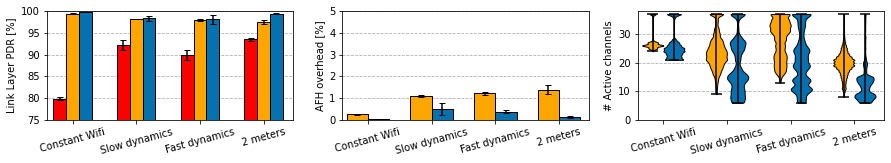

In [153]:
x_axis = np.arange(4)*1.5

fig,ax = plt.subplots(1,3, figsize=(15,2), sharex=True)
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)
ax[2].set_axisbelow(True)

# PDR
ax[0].bar(x_axis-0.3,
             nafh_pdr,
             yerr=nafh_pdr_std,
             width=0.3,
             capsize=3,
             linewidth=1,
             edgecolor='black',
             color='red')
ax[0].bar(x_axis,
             eafh_pdr,
             yerr=eafh_pdr_std,
             width=0.3,
             capsize=3,
             linewidth=1,
             edgecolor='black',
             color=eAFH_COLOR)
ax[0].bar(x_axis+0.3,
             graz_pdr,
             yerr=graz_pdr_std,
             width=0.3,
             capsize=3,
             linewidth=1,
             edgecolor='black',
             color=GRAZ_COLOR)
ax[0].axis([-0.6,5.2,75,100])
ax[0].grid(axis='y',linestyle='dashed')
ax[0].set_xticks(x_axis)
ax[0].set_xticklabels(["Constant Wifi", "Slow dynamics", "Fast dynamics", "2 meters"], rotation=15)
ax[0].set_ylabel("Link Layer PDR [%]")


# Updates
ax[1].bar(x_axis-0.25,
             eafh_upd,
             yerr=eafh_upd_std,
             width=0.5,
             capsize=3,
             linewidth=1,
             edgecolor='black',
             color=eAFH_COLOR)
ax[1].bar(x_axis+0.25,
             graz_upd,
             yerr=graz_upd_std,
             width=0.5,
             capsize=3,
             linewidth=1,
             edgecolor='black',
             color=GRAZ_COLOR)
ax[1].axis([-0.6,5.2,0,5])
ax[1].grid(axis='y',linestyle='dashed')
ax[1].set_xticks(x_axis)
ax[1].set_xticklabels(["Constant Wifi", "Slow dynamics", "Fast dynamics", "2 meters"], rotation=15)
ax[1].set_ylabel("AFH overhead [%]")

# Active Channels
parts = ax[2].violinplot(eafh_channels,
                positions=x_axis-0.25,)
for pc in parts['bodies']:
    pc.set_facecolor(eAFH_COLOR)
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cbars'].set_color("black")
parts['cmaxes'].set_color("black")
parts['cmins'].set_color("black")
parts = ax[2].violinplot(graz_channels,
                positions=x_axis+0.25,)
for pc in parts['bodies']:
    pc.set_facecolor(GRAZ_COLOR)
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cbars'].set_color("black")
parts['cmaxes'].set_color("black")
parts['cmins'].set_color("black")
ax[2].axis([-0.6,5.2,0,38])
ax[2].grid(axis='y',linestyle='dashed')
ax[2].set_xticklabels(["Constant Wifi", "Slow dynamics", "Fast dynamics", "2 meters"], rotation=15)
ax[2].set_ylabel("# Active channels")
plt.savefig('eval_comparison.pdf', bbox_inches='tight', transparent=True)

In [ ]:
x_axis = np.array(range(0,5))*.75+0.5

fig,ax = plt.subplots(2,1, figsize=(10,5), sharex=True)
ax[0].set_axisbelow(True)
ax[1].set_axisbelow(True)


# PDR VS wifi
ax[0].bar(x_axis-0.1,
             parsed_exclusion_continuous_pdr,
             yerr=parsed_exclusion_continuous_pdr_std,
             width=0.2)
ax[0].bar(x_axis+0.1,
             parsed_exclusion_1_11_pdr,
             yerr=parsed_exclusion_1_11_pdr_std,
             width=0.2)
ax[0].set_ylabel('Link-layer PDR [%]')
ax[0].set_xticks(x_axis)
#ax[0].set_xticklabels(['No AFH','Constant, 2 sec','Constant, 30 sec','Exponential, 2 sec','eAFH'])
ax[0].axis([0,4,90,100])
ax[0].set_title('Channel Inclusion')
ax[0].grid(axis='y',linestyle='dashed')
ax[0].legend(["Continous Wifi channel 1","1 min channel 1, 1 min channel 11"], loc='lower right')

ax[0].text(0.22,90.5,f'{parsed_exclusion_continuous_pdr[0]:.1f}%')
ax[0].text(0.97,90.5,f'{parsed_exclusion_continuous_pdr[1]:.1f}%')



# Channels VS wifi
ax[1].bar(x_axis-0.1,
             parsed_exclusion_continuous_updates/5,
             yerr=parsed_exclusion_continuous_updates_std/5,
             width=0.2)
ax[1].bar(x_axis+0.1,
             parsed_exclusion_1_11_updates/5,
             yerr=parsed_exclusion_1_11_updates_std/5,
             width=0.2)
ax[1].set_ylabel('# Updates / min')
ax[1].set_xlabel('Short-term PDR Window Size')
ax[1].set_xticks(x_axis)
ax[1].set_xticklabels(['No AFH','Constant, 2 sec','Constant, 30 sec','eAFH: Exp','eAFH: Exp + Nearby'])
ax[1].axis([0,4,0,100])
ax[1].grid(axis='y',linestyle='dashed')

plt.show()

In [ ]:
exp=23
t = np.arange(0,exp_stats[exp]['channel_map'].shape[0])*CONNECTION_EVENT/60
plt.plot(t,np.sum(exp_stats[exp]['channel_map'],axis=1))

In [ ]:
def get_concatenated_channel_maps(exps):
    chans = []
    shortest = 999999999
    for i in range(len(exps)):
        shortest = np.minimum(shortest, exps[i]['channel_map'].shape[0])
    for i in range(len(exps)):
        chans.append(np.sum(exps[i]['channel_map'],axis=1)[:shortest])
    return np.array(chans,dtype=np.float)

## Macro-eval, Graz / eAFH vs Wifi 1,11

In [ ]:
graz = get_concatenated_channel_maps(exp_stats[0:5])
graz_chan = np.nanmean(graz,axis=0)
graz_std = np.nanstd(graz,axis=0)
eAFH = get_concatenated_channel_maps(exp_stats[10:15])
eAFH_chan = np.nanmean(eAFH,axis=0)
eAFH_std = np.nanstd(eAFH,axis=0)

t = np.arange(0,np.minimum(graz.shape[1],eAFH.shape[1]))*CONNECTION_EVENT/60
graz_chan = graz_chan[:t.shape[0]]
graz_std = graz_std[:t.shape[0]]
eAFH_chan = eAFH_chan[:t.shape[0]]
eAFH_std = eAFH_std[:t.shape[0]]

fig,ax = plt.subplots(1,1, figsize=(6,4), sharex=True)
ax.plot(t,
        graz_chan)
ax.fill_between(t,
                graz_chan+graz_std/2,
                graz_chan-graz_std/2,
                alpha=0.2)
ax.plot(t,
        eAFH_chan)
ax.fill_between(t,
                eAFH_chan+eAFH_std/2,
                eAFH_chan-eAFH_std/2, alpha=0.2)
ax.axis([0,t[-1],0,40])
ax.set_xlabel("Time [min]")
ax.set_ylabel("Active Channels")
ax.legend(["Graz","eAFH"],
          loc='lower left')
ax.grid(axis='y',linestyle='dashed')

r_1 = matplotlib.patches.Rectangle((1.15,0),
                                    0.98,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray")
r_11 = matplotlib.patches.Rectangle((2.2,0),
                                    0.98,
                                    40,
                                    alpha=0.2,
                                    facecolor="gray")
ax.add_patch(r_1)
ax.add_patch(r_11)
ax.text(1.15+0.12,1,"Channel 1")
ax.text(2.2+0.09,1,"Channel 11")


## Macro-eval, Graz / eAFH vs Wifi 1,11

In [ ]:
graz = get_concatenated_channel_maps(exp_stats[15:20])
graz_chan = np.nanmean(graz,axis=0)
graz_std = np.nanstd(graz,axis=0)
eAFH = get_concatenated_channel_maps(exp_stats[15:25])
eAFH_chan = np.nanmean(eAFH,axis=0)
eAFH_std = np.nanstd(eAFH,axis=0)

t = np.arange(0,np.minimum(graz.shape[1],eAFH.shape[1]))*CONNECTION_EVENT/60
graz_chan = graz_chan[:t.shape[0]]
graz_std = graz_std[:t.shape[0]]
eAFH_chan = eAFH_chan[:t.shape[0]]
eAFH_std = eAFH_std[:t.shape[0]]

fig,ax = plt.subplots(1,1, figsize=(6,4), sharex=True)

# for i in range(1,15):
#     ax.plot([0.5*i,0.5*i],[0,40],color="black",alpha=0.5)

ax.plot(t,
        graz_chan)
ax.fill_between(t,
                np.max(graz,axis=0),
                np.min(graz,axis=0),
                alpha=0.2)
# ax.plot(t,
#         eAFH_chan)
# ax.fill_between(t,
#                 eAFH_chan+eAFH_std/2,
#                 eAFH_chan-eAFH_std/2, alpha=0.2)
ax.axis([0,t[-1],0,40])
ax.set_xlabel("Time [min]")
ax.set_ylabel("Active Channels")
ax.legend(["Graz","eAFH"],
          loc='lower left')
ax.grid(axis='y',linestyle='dashed')


## Graz & eAFH vs random Wifi, 1 representative run

In [ ]:
graz_run = np.sum(exp_stats[15]['channel_map'],axis=1)
eAFH_run = np.sum(exp_stats[20]['channel_map'],axis=1)

t = np.arange(0,29000)*CONNECTION_EVENT/60#np.minimum(graz_run.shape[0],eAFH_run.shape[0]))*CONNECTION_EVENT/60
# reshape
graz_run = graz_run[:t.shape[0]]
eAFH_run = eAFH_run[200:t.shape[0]+200]


fig,ax = plt.subplots(2,1, figsize=(6,4), sharex=True)


ax[0].plot(t,
        graz_run,
        linewidth=2,
        color=GRAZ_COLOR)
r_1 = matplotlib.patches.Rectangle((0.7,0),
                                    7.1,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray")
ax[0].add_patch(r_1)

ax[1].plot(t,
        eAFH_run,
        linewidth=2,
        color=eAFH_COLOR)
r_1 = matplotlib.patches.Rectangle((0.7,0),
                                    7.1,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray")
ax[1].add_patch(r_1)

ax[0].axis([0,t[-1],0,40])
ax[0].set_ylabel("Active Channels")
ax[0].grid(axis='y',linestyle='dashed')
ax[0].legend(["AFH-Spörk"],loc='lower left')

ax[1].set_xlabel("Time [min]")
ax[1].axis([0,t[-1],0,40])
ax[1].set_ylabel("Active Channels")
ax[1].legend(["eAFH"],loc='lower left')
ax[1].grid(axis='y',linestyle='dashed')

plt.tight_layout()
plt.subplots_adjust(hspace=0.11)

#matplotlib.rcParams.update({'font.size': 14})
plt.savefig('macro_vs_random_chans.pdf', bbox_inches='tight', transparent=True)

## Graz & eAFH vs Channel 1 one-off

In [ ]:
graz_run = np.sum(exp_stats[26]['channel_map'],axis=1)
eAFH_run = np.sum(exp_stats[25]['channel_map'],axis=1)
graz_staleness = np.nanmean(exp_stats[26]['staleness'],axis=1)*CONNECTION_EVENT
eAFH_staleness = np.nanmean(exp_stats[25]['staleness'],axis=1)*CONNECTION_EVENT

t = np.arange(0,13900)*CONNECTION_EVENT/60     #np.minimum(graz_run.shape[0],eAFH_run.shape[0]))*CONNECTION_EVENT/60
# reshape
graz_run = graz_run[:t.shape[0]]
eAFH_run = eAFH_run[500:14400]
graz_staleness = graz_staleness[:t.shape[0]]
eAFH_staleness = eAFH_staleness[500:14400]

fig,ax = plt.subplots(2,1, figsize=(6,4), sharex=True)


ax[0].plot(t,
        graz_run,
        linewidth=2,
        color=GRAZ_COLOR)
ax[0].plot(t,
        eAFH_run,
        linewidth=2,
        color=eAFH_COLOR)
r_1 = matplotlib.patches.Rectangle((1.08,0),
                                    1.0,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray")
ax[0].add_patch(r_1)
ax[0].text(1.15+0.06,16.8,"Interference")
ax[1].text(1.15+0.14,53,"Channel 1")
ax[0].axis([0,t[-1],15,40])
ax[0].set_ylabel("Active Channels")
ax[0].legend(["AFH-Spörk","eAFH"],loc='lower right')
ax[0].grid(axis='y',linestyle='dashed')


ax[1].plot(t,
        graz_staleness,
        linewidth=2,
        color=GRAZ_COLOR)
ax[1].plot(t,
        eAFH_staleness,
        linewidth=2,
        color=eAFH_COLOR)
r_1 = matplotlib.patches.Rectangle((1.08,0),
                                    1.0,
                                   100,
                                   alpha=0.2,
                                   facecolor="gray")
ax[1].add_patch(r_1)

ax[1].set_xlabel("Time [min]")
ax[1].axis([0,t[-1],0,60])
ax[1].set_ylabel("Data Staleness [sec]")
#ax[0].legend(["Graz","eAFH"],loc='lower left')
ax[1].grid(axis='y',linestyle='dashed')

plt.tight_layout()
plt.subplots_adjust(hspace=0.11)

#matplotlib.rcParams.update({'font.size': 14})
plt.savefig('macro_vs_chan_1_one_off.pdf', bbox_inches='tight', transparent=True)

In [ ]:
exp_stats[20]['pdr']

## Design: Role of explo vs Wifi 1 30 seconds

In [ ]:
graz_run1 = np.sum(exp_stats[34]['channel_map'],axis=1)
eAFH_run1 = np.sum(exp_stats[33]['channel_map'],axis=1)
graz_run2 = np.sum(exp_stats[36]['channel_map'],axis=1)
eAFH_run2 = np.sum(exp_stats[35]['channel_map'],axis=1)


t = np.arange(0,13900)*CONNECTION_EVENT/60     #np.minimum(graz_run.shape[0],eAFH_run.shape[0]))*CONNECTION_EVENT/60
# reshape
graz_run1 = graz_run1[:t.shape[0]]
eAFH_run1 = eAFH_run1[650:t.shape[0]+650]
graz_run2 = graz_run2[100:t.shape[0]+100]
eAFH_run2 = eAFH_run2[:t.shape[0]+0]

fig,ax = plt.subplots(2,1, figsize=(6,4), sharex=True)


ax[0].plot(t,
        eAFH_run1,
        linewidth=2,
        color=eAFH_COLOR)
ax[0].plot(t,
        graz_run1,
        linewidth=2,
        color=GRAZ_COLOR)
r_1 = matplotlib.patches.Rectangle((0.6,0),
                                    .5,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray")
ax[0].add_patch(r_1)
ax[0].text(0.7,2,"Ch. 1")
ax[0].axis([0,t[-1],0,40])
ax[0].set_ylabel("Active Channels")
ax[0].legend(["eAFH: Exclusion+Exploration", "AFH-Spörk: Exclusion-only","Wifi Interference"],loc='lower right')
ax[0].grid(axis='y',linestyle='dashed')


ax[1].plot(t,
        eAFH_run2,
        linewidth=2,
        color=eAFH_COLOR)
ax[1].plot(t,
        graz_run2,
        linewidth=2,
        color=GRAZ_COLOR)
ax[1].add_patch(matplotlib.patches.Rectangle((.3,0),
                                    .45,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray"))
ax[1].add_patch(matplotlib.patches.Rectangle((1.15,0),
                                    .45,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray"))
ax[1].add_patch(matplotlib.patches.Rectangle((2.0,0),
                                    .45,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray"))
ax[1].add_patch(matplotlib.patches.Rectangle((2.9,0),
                                    .45,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray"))
ax[1].add_patch(matplotlib.patches.Rectangle((3.8,0),
                                    .45,
                                   40,
                                   alpha=0.2,
                                   facecolor="gray"))
ax[1].text(.35,2,"Ch. 1")
ax[1].text(1.2,2,"Ch. 3")
ax[1].text(2.05,2,"Ch. 7")
ax[1].text(2.98,2,"Ch. 9")
ax[1].text(3.8,2,"Ch. 11")


ax[1].set_xlabel("Time [min]")
ax[1].axis([0,t[-1],0,40])
ax[1].set_ylabel("Active Channels")
#ax[0].legend(["Graz","eAFH"],loc='lower left')
ax[1].grid(axis='y',linestyle='dashed')

plt.tight_layout()
plt.subplots_adjust(hspace=0.11)

matplotlib.rcParams.update({'font.size': 10})
plt.savefig('design_exploration.pdf', bbox_inches='tight', transparent=True)

{'bodies': [<matplotlib.collections.PolyCollection at 0x12b2e4fd0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x12b1e2f10>,
 'cmins': <matplotlib.collections.LineCollection at 0x12b2f4910>,
 'cbars': <matplotlib.collections.LineCollection at 0x12b2f4cd0>}

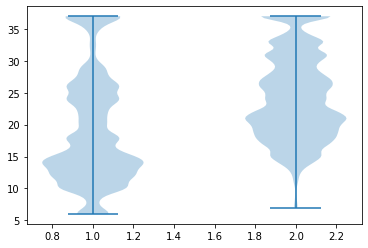

In [17]:
graz = np.concatenate([np.sum(exp_stats[15]['channel_map'],axis=1),
               np.sum(exp_stats[16]['channel_map'],axis=1),
               np.sum(exp_stats[17]['channel_map'],axis=1),
               np.sum(exp_stats[18]['channel_map'],axis=1),
               np.sum(exp_stats[19]['channel_map'],axis=1)])

eafh = np.concatenate([np.sum(exp_stats[20]['channel_map'],axis=1),
               np.sum(exp_stats[21]['channel_map'],axis=1),
               np.sum(exp_stats[22]['channel_map'],axis=1),
               np.sum(exp_stats[23]['channel_map'],axis=1),
               np.sum(exp_stats[24]['channel_map'],axis=1)])

plt.violinplot([graz,eafh])